因子1 Alpha191 alpha24

3.025683879852295
Initialize dataview success.


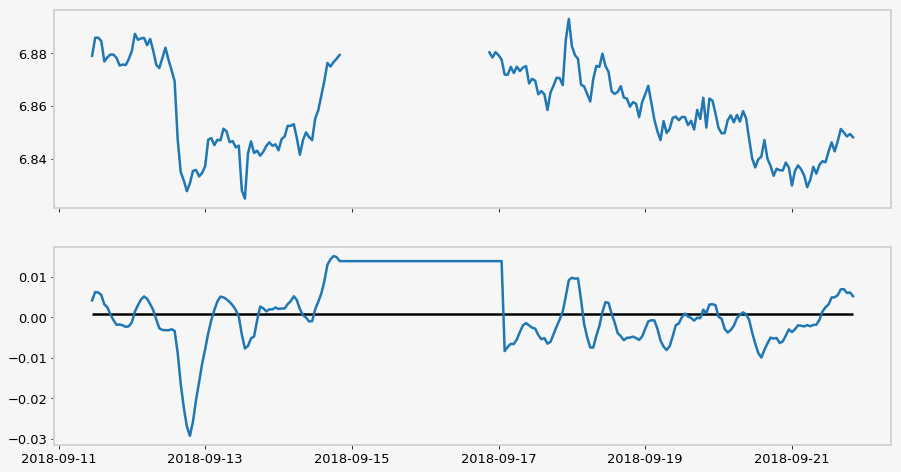

In [148]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/OANDA_M1'
props = {'fields': 'open,high,low,close,volume','symbol': 'USD_CNH:oanda', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
import matplotlib.pyplot as plt

def plot_chart(close,alpha,alpha_mean=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    ax1.hlines(alpha_mean, alpha.index[-250], alpha.index[-1])
    # plt.savefig('good')
    plt.show()
def RankPct(df):
    return df.rank(axis=1, pct=True)
alpha24 = dv.add_formula('alpha24','Sma(close-Delay(close,5),5,1)',add_data=True, register_funcs={'RankPct':RankPct})
import numpy as np
a=np.nan_to_num(alpha24.values)
alpha24_mean=np.mean(a)
alpha24_plot = dv.get_ts('alpha24', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, alpha24_plot,alpha24_mean)

In [140]:
np.mean(a)

0.00082097971660189967

In [150]:

# 进场信号
long = dv.add_formula('longAlpha24','If(Sma(close-Delay(close,5),5,1)>0.00082097971660189967 ,2,0)', add_data=True)
short = dv.add_formula("shortAlpha24","If(Sma(close-Delay(close,5),5,1)<=0.00082097971660189967 ,-2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongAlpha24","If(shortAlpha24==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortAlpha24","If(longAlpha24==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha024')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdAlpha1, dv,'longAlpha24','shortAlpha24','closeLongAlpha24','closeShortAlpha24', 100, 0.05, 0.3)
tdAlpha1.create_event_report(sig_type="long_short")


Field [longAlpha24] is overwritten.
Field [shortAlpha24] is overwritten.
Field [closeLongAlpha24] is overwritten.
Field [closeShortAlpha24] is overwritten.
Nan Data Count (should be zero) : 0;  Percentage of effective data: 36%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 34%
*****-Summary-*****
Event Analysis
                        win      loss       all
t-stat               19.799   -53.823   -21.077
p-value               0.000     0.000     0.000
mean                  0.002    -0.002    -0.001
std                   0.002     0.001     0.002
info_ratio            1.003    -1.379    -0.482
skewness              1.493    -1.615     0.945
kurtosis              2.191     4.254     3.800
pct5                  0.000    -0.005    -0.004
pct25                 0.000    -0.003    -0.002
pct50                 0.002    -0.002    -0.001
pct75                 0.003    -0.001    -0.000
pct95                 0.007    -0.000     0.003
occurance           391.000  1524.000  19

In [151]:
tdAlpha1.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               17.861  -34.314  -11.427
p-value               0.000    0.000    0.000
mean                  0.002   -0.002   -0.001
std                   0.002    0.002    0.003
info_ratio            1.134   -1.267   -0.365
skewness              1.042   -1.769    0.497
kurtosis              0.399    4.586    2.018
pct5                  0.000   -0.005   -0.005
pct25                 0.001   -0.003   -0.002
pct50                 0.002   -0.002   -0.001
pct75                 0.003   -0.001    0.000
pct95                 0.007   -0.000    0.004
occurance           249.000  734.000  983.000
win_ratio               NaN      NaN    0.253
win_mean/loss_mean      NaN      NaN    1.137


In [152]:
tdAlpha1.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                9.767  -43.269  -19.765
p-value               0.000    0.000    0.000
mean                  0.002   -0.002   -0.001
std                   0.002    0.001    0.002
info_ratio            0.823   -1.540   -0.648
skewness              2.038   -1.115    1.687
kurtosis              4.052    1.399    7.767
pct5                  0.000   -0.004   -0.004
pct25                 0.000   -0.003   -0.002
pct50                 0.001   -0.002   -0.001
pct75                 0.003   -0.001   -0.001
pct95                 0.007   -0.000    0.002
occurance           142.000  790.000  932.000
win_ratio               NaN      NaN    0.152
win_mean/loss_mean      NaN      NaN    1.036


前面所写的程序使用alpha191的第24个因子（公式为Sma(close-Delay(close,5),5,1)），从前面的图中我们可以看出，输出的alpha因子将价格变化变得更加平滑，同时没有像其他的均线一样出现延后的情况，当alpha24因子一旦越过平均线0.00082097971660189967，价格图表也将出现明显的下跌或者上升，此因子有一定的预测作用。

因此，我假设当alpha24因子跌破其均线时，就做空美元，当alpha24因子涨过其均线时，就做多美元。

对因子进行绩效分析之后发现，该因子的盈亏比超过1，但win_ratio较低。

因子2 蜡烛图形态Hammer和Hikkake

Initialize dataview success.
symbol               BTCUSDT:binance
trade_date                          
2018-09-04 12:00:00            100.0
2018-09-05 22:00:00            100.0
2018-09-07 12:00:00            100.0
2018-09-08 20:00:00            100.0
2018-09-16 02:00:00            100.0
2018-09-16 22:00:00            100.0
2018-09-18 04:00:00            100.0
2018-09-20 10:00:00            100.0


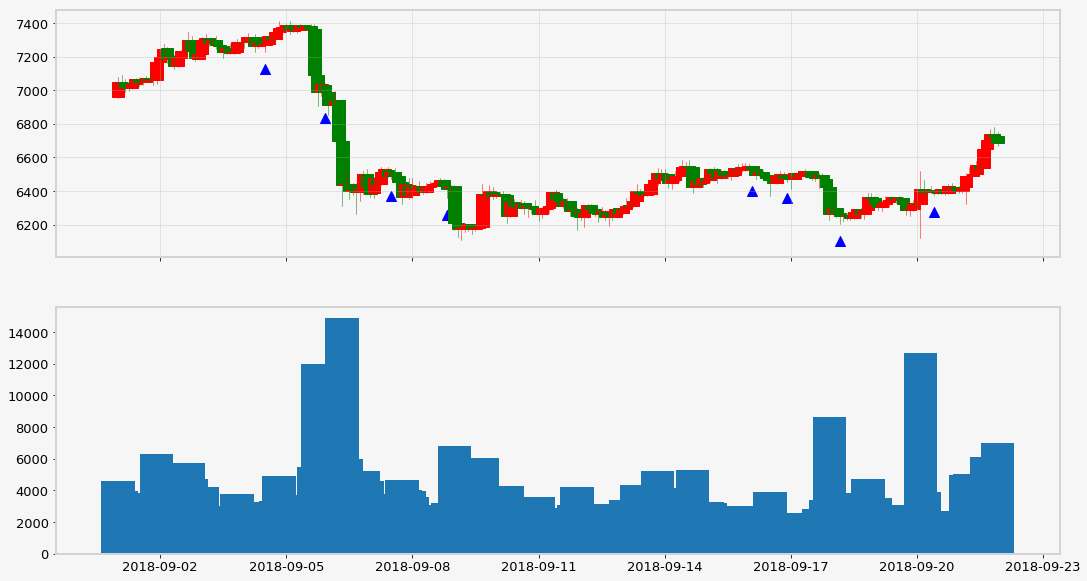

In [109]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '2H',
         'start_date':20180901000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
HAMMER = dv1H.add_formula('HAMMER', "If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HAMMERVolume = dv1H.get_ts('HAMMER', date_type='datetime')
print(HAMMERVolume[HAMMERVolume['BTCUSDT:binance']==100])

from matplotlib.pylab import date2num
import matplotlib.pyplot as plt
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
HAMMERVolumeX = HAMMERVolume[HAMMERVolume['BTCUSDT:binance']==100].index
HAMMERVolumeY = data1H.loc[HAMMERVolumeX].low-100
draw_candle(candle, HAMMERVolumeX, HAMMERVolumeY)

symbol               BTCUSDT:binance
trade_date                          
2018-09-02 08:00:00            100.0
2018-09-04 00:00:00            100.0
2018-09-05 06:00:00            100.0
2018-09-05 22:00:00            100.0
2018-09-06 12:00:00            100.0
2018-09-09 10:00:00            100.0
2018-09-10 12:00:00            100.0
2018-09-11 22:00:00            100.0
2018-09-15 12:00:00            100.0
2018-09-16 02:00:00            100.0
2018-09-16 08:00:00            100.0
2018-09-17 20:00:00            100.0
2018-09-20 06:00:00            100.0


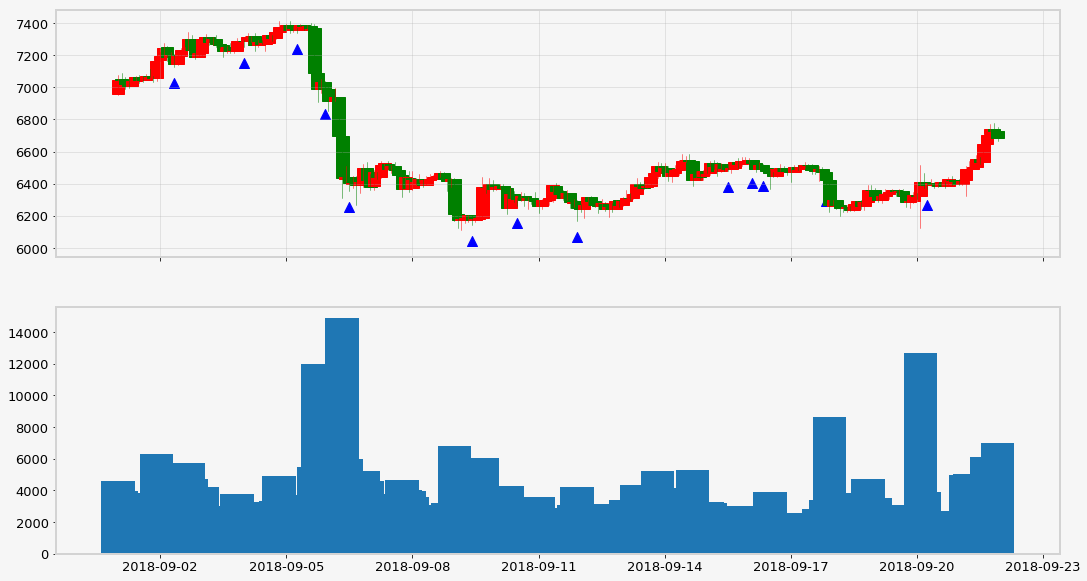

In [110]:
HIKKAKE = dv1H.add_formula('HIKKAKE', "If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HIKKAKEVolume = dv1H.get_ts('HIKKAKE', date_type='datetime')
print(HIKKAKEVolume[HIKKAKEVolume['BTCUSDT:binance']==100])
HIKKAKEVolumeX = HIKKAKEVolume[HIKKAKEVolume['BTCUSDT:binance']==100].index
HIKKAKEVolumeY = data1H.loc[HIKKAKEVolumeX].low-100
draw_candle(candle, HIKKAKEVolumeX,HIKKAKEVolumeY)

In [155]:
long = dv.add_formula('longCandle',"If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100) ,2,0)", add_data=True)
short = dv.add_formula("shortCandle","If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),-2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongCandle","If(shortCandle==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortCandle","If(longCandle==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdCandle= TimingDigger(output_folder=".", output_format='pdf',signal_name='Candle')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdCandle, dv,'longCandle','shortCandle','closeLongCandle','closeShortCandle', 100, 0.05, 0.3)
tdCandle.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               6.941   -9.871   -3.943
p-value              0.000    0.000    0.000
mean                 0.003   -0.003   -0.001
std                  0.003    0.003    0.004
info_ratio           1.023   -0.992   -0.326
skewness             1.606   -1.620   -0.393
kurtosis             2.719    2.362    1.812
pct5                 0.000   -0.009   -0.008
pct25                0.001   -0.005   -0.003
pct50                0.001   -0.002   -0.001
pct75                0.004   -0.001    0.001
pct95                0.007   -0.000    0.005
occurance           47.000  100.000  147.000
win_ratio              NaN      NaN    0.320
win_mean/loss_mean     NaN      NaN    0.826


In [156]:
tdCandle.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.699  -5.707  -1.159
p-value              0.000   0.000   0.252
mean                 0.002  -0.002  -0.000
std                  0.002   0.002   0.003
info_ratio           1.108  -0.979  -0.159
skewness             0.840  -1.623   0.020
kurtosis            -0.184   2.165   1.113
pct5                 0.000  -0.006  -0.005
pct25                0.000  -0.003  -0.002
pct50                0.001  -0.001  -0.000
pct75                0.004  -0.001   0.000
pct95                0.006  -0.000   0.005
occurance           19.000  35.000  54.000
win_ratio              NaN     NaN   0.352
win_mean/loss_mean     NaN     NaN   1.178


In [157]:
tdCandle.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.181  -8.642  -3.878
p-value              0.000   0.000   0.000
mean                 0.003  -0.004  -0.002
std                  0.003   0.003   0.004
info_ratio           0.997  -1.080  -0.404
skewness             1.739  -1.368  -0.276
kurtosis             2.726   1.283   1.329
pct5                 0.000  -0.012  -0.010
pct25                0.001  -0.005  -0.004
pct50                0.001  -0.003  -0.001
pct75                0.004  -0.001   0.001
pct95                0.009  -0.000   0.004
occurance           28.000  65.000  93.000
win_ratio              NaN     NaN   0.301
win_mean/loss_mean     NaN     NaN   0.735


第二部分使用了蜡烛图的两个形态同时作为对比特币投资的决策因子。首先画的图是形态Hammer出现时间与价格的走势图，从图中可以看出，大部分时间该形态都出现在一波涨势之前，但未观察到其于交易量的关系。第二个画的图为形态Hikkake出现时间与价格的走势图，从图中可以看出，当大市暴跌时，该形态都做出了预测，同时在大部分时间，市场都会在该指标出现之后有少许下跌，同时可以观察到，该指标会让比特币交易量有所提升。

因此，我们做出假设，当出现Hammer形态时我们可以做多；在出现Hikkake形态时，我们可以做空。

对因子进行绩效分析之后发现，该因子无论是盈亏比还是win_ratio都不太理想，但是单边做多的策略是三者中表现最好的一个，可以猜测Hammer形态对预测涨势有较好效果。